In [2]:
import numpy as np
import pandas as pd

import strawb
import strawb.sensors.camera as camera
import os
import matplotlib.pyplot as plt

# Load files from the ONC server
Be careful, depending on the amount of data this can take a while!!

## Version 1: Manual version
If file name is known. If not use the database DB

In [3]:
# onc_downloader = strawb.ONCDownloader(showInfo=False)

# # download files selected by `date_from`, `date_to`,...
# onc_downloader.download_structured(extensions='hdf5',
#                                    date_from = '2021-07-01T23:00:00.000Z',
#                                    date_to = '2021-07-01T23:59:59.000Z',
#                                    dev_codes ='TUMPMTSPECTROMETER002',
#                                    dataProductCode = 'MSSCD',  # short for 'dataProductName': 'Mini Spectrometer Sensor Camera Data',
#                                   )

In [4]:
# # where data is located on the LRZ VM
# basepath = join(strawb.Config.raw_data_dir, 'tumpmtspectrometer001/2021_09/')
# file_name = os.path.join(basepath, 'TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5')


# cam_run = camera.FileHandler(file_name)
# picture_handler = camera.Images(cam_run)

## Version 2 (recommended): use the database (DB) to find a valid file

In [5]:
# load DB
db = strawb.SyncDBHandler(file_name='Default')  # loads the db
db.load_onc_db_update(save_db=True)  # update the DB, could take some time if it has to load info. from ONC

100%|██████████| 9/9 [00:03<00:00,  2.26devices/s, i=TUMSTANDARDMODULE004] 
update synced form          0 to          0; delta:          0
0files [00:00, ?files/s]
0files [00:00, ?files/s]


/Users/kilian/vscode/strawb_package/src/strawb/sync_db_handler/__init__.py:225: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(dataframe2add_diff)  # for newer pandas versions: concat = append


,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,path,uncompressedFileSize,outPath,fullPath,synced,h5_attrs,file_version
fullPath,,,,,,,,,,,,,,,,,
/Users/kilian/vscode/strawb_package/raw_module_data/tumstandardmodule004/2022_05/TUMSTANDARDMODULE004_20220502T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_05,2022-05-03 01:01:19.658000+00:00,None,SMRD,2022-05-02 00:00:00+00:00,2022-05-02 23:59:59.999000+00:00,TUMSTANDARDMODULE004,2394257,TUMSTANDARDMODULE004_20220502T000000.000Z-SDAQ...,2022-05-03 01:01:19.761000+00:00,07/22/17,2394257,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumstandardmodule004/2022_05/TUMSTANDARDMODULE004_20220503T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_05,2022-05-04 01:01:15.148000+00:00,None,SMRD,2022-05-03 00:00:00+00:00,2022-05-03 23:59:59.999000+00:00,TUMSTANDARDMODULE004,2380177,TUMSTANDARDMODULE004_20220503T000000.000Z-SDAQ...,2022-05-04 01:01:15.359000+00:00,07/30/92,2380177,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumstandardmodule004/2022_05/TUMSTANDARDMODULE004_20220504T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_05,2022-05-05 01:01:17.465000+00:00,None,SMRD,2022-05-04 00:00:00+00:00,2022-05-04 23:59:59.999000+00:00,TUMSTANDARDMODULE004,2383990,TUMSTANDARDMODULE004_20220504T000000.000Z-SDAQ...,2022-05-05 01:01:17.541000+00:00,07/39/38,2383990,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumstandardmodule001/2022_05/TUMSTANDARDMODULE001_20220502T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_05,2022-05-03 01:16:24.175000+00:00,None,SMRD,2022-05-02 00:00:00+00:00,2022-05-02 23:59:59.999000+00:00,TUMSTANDARDMODULE001,2422357,TUMSTANDARDMODULE001_20220502T000000.000Z-SDAQ...,2022-05-03 01:16:24.508000+00:00,07/22/27,2422357,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumstandardmodule001/2022_05/TUMSTANDARDMODULE001_20220502T000000.000Z.txt,/NA_Archive_05,2022-05-03 05:11:56.335000+00:00,gz,LF,2022-05-02 00:00:00+00:00,2022-05-03 00:00:00+00:00,TUMSTANDARDMODULE001,139133,TUMSTANDARDMODULE001_20220502T000000.000Z.txt,2022-05-03 05:11:56.527000+00:00,07/23/53,1466590,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220504T220000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-05-05 01:39:06.033000+00:00,None,MSSCD,2022-05-04 22:00:00+00:00,2022-05-04 22:59:59.999000+00:00,TUMPMTSPECTROMETER001,50916287,TUMPMTSPECTROMETER001_20220504T220000.000Z-SDA...,2022-05-05 01:39:07.656000+00:00,07/39/54,50916287,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220504T230000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_05,2022-05-05 01:39:05.101000+00:00,None,PMTSD,2022-05-04 23:00:00+00:00,2022-05-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,25198866,TUMPMTSPECTROMETER001_20220504T230000.000Z-SDA...,2022-05-05 01:39:05.832000+00:00,07/39/54,25198866,/Users/kilian/vscode/strawb_package/raw_module...,/Users/kilian/vscode/strawb_package/raw_module...,False,None,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220504T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-05-05 01:39:03.453000+00:00,None,MSSCD,2022-05-04 23:00:00+00:

Print some info from the DB

In [6]:
print(db.dataframe.columns)

### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR, 
# works only if hdf5 attributes are imported from files on disc
#print(db.dataframe.measurement_type.unique())

### these are the parts of each module that produce data
print(db.dataframe.dataProductCode.unique())

Index(['archiveLocation', 'archivedDate', 'compression', 'dataProductCode',
       'dateFrom', 'dateTo', 'deviceCode', 'fileSize', 'filename',
       'modifyDate', 'path', 'uncompressedFileSize', 'outPath', 'fullPath',
       'synced', 'h5_attrs', 'dev_code', 'file_end', 'file_id', 'file_start',
       'following_file_id', 'name', 'previous_file_id', 'rollover_interval',
       'run_end', 'run_start', 'write_period', 'file_version'],
      dtype='object')
['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
['LF' 'PMTSD' 'SMRD' 'MSRD' 'PMTTC' 'LIDARSD' 'LIDARRD' 'LIDARTF' 'MTSD'
 'MSCR' 'MSCRCC' 'MSID' 'MTRD' None 'LIDARTOT' 'PMTRD' 'MSSCD' 'MSSD'
 'MTTOT' 'PMTTOT']


### Select (a) file(s) of interest

In [15]:
mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module

## select the file for the biolumi event
timestamp = pd.Timestamp('2021-09-04T23:44:09').tz_localize('UTC')
mask &= db.dataframe.dateFrom <= timestamp 
mask &= db.dataframe.dateTo >= timestamp

### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask]

,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,file_id,file_start,following_file_id,name,previous_file_id,rollover_interval,run_end,run_start,write_period,file_version
fullPath,,,,,,,,,,,,,,,,,,,,,
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:24.463000+00:00,None,MSSCD,2021-09-04 23:00:00+00:00,2021-09-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,58043955,TUMPMTSPECTROMETER001_20210904T230000.000Z-SDA...,2021-09-05 01:51:26.475000+00:00,...,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


### Download the missing files which aren't synced so far from `db.dataframe[mask]`

In [16]:
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        save_db=True,
    )  # update the DB

update synced form          0 to          0; delta:          0
  In total: 1 files; skips synced: 0; size to download: 55.36 MB, from deviceCode: ['TUMPMTSPECTROMETER001']

-> Download the files from the ONC server
100%|██████████| 1/1 [00:11<00:00, 11.84s/file, i=TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5]
Downloaded - Directory: /Users/kilian/vscode/strawb_package/raw_module_data; Files: 1; Size: 58.0 MB; Time: 11 seconds; Speed: 4.9 MB/s
update synced form          0 to          1; delta:          1

-> Update hdf5 attributes
100%|██████████| 1/1 [00:00<00:00,  9.34files/s, i=0]

-> Update file version
100%|██████████| 1/1 [00:00<00:00,  9.67files/s, i=0]

-> Add to db

-> save DB to disc


# Import the file to the Camera Module 

In [17]:
# select the filename
file_name = db.dataframe.fullPath[mask].iloc[-1]
print(file_name)

# create an instance of the Camera
camera = strawb.sensors.camera.Camera(file_name)

/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5


### Print some parameters

In [18]:
print(f'Module: {camera.file_handler.module}')
print(f'Number of Frames: {camera.file_handler.exposure_time.shape[0]}')
print(f'Date: {np.min(camera.file_handler.time.asdatetime()[:])} - {np.max(camera.file_handler.time.asdatetime()[:])}')
print(f'Exposure Times [s]: {np.unique(camera.file_handler.exposure_time)}')

Module: TUMPMTSPECTROMETER001
Number of Frames: 36
Date: 2021-09-04T22:59:18.344365 - 2021-09-04T23:57:27.277572
Exposure Times [s]: [52.5]


### Mask images to export (here only one)

In [19]:
# mask over a threshold + mask invalid frames + mask no lucifer enabled
mask = (camera.images.integrated_minus_dark > 1e6) & camera.images.invalid_mask

index = np.argsort(camera.images.integrated_minus_dark)  # sort by charge [min,...,max]
index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
index = index[::-1]  # revers the order
print(index)

[27]


## Export the image as png and store it on disc

In [20]:
camera.images.image2png(
    index=index, 
    directory="./figures", # add your preferred dir here
    f_name_formatter='bright_test_pic_{i}_{datetime}.png')  # save the images

['/Users/kilian/vscode/strawb_package/examples/figures/bright_test_pic_0_2021_09_04_23_44_09.png']

## Show one image here

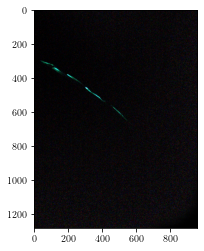

In [21]:
plt.figure()
plt.imshow(camera.images._rgb[0,:,:]/255)
plt.savefig("figures/biolumi_demo.pdf", backend="pdf")
plt.savefig("figures/biolumi_demo.png", dpi=120)

## How to access the raw data (numpy)

In [22]:
# The raw pixel values are NOT loaded by default to the module to save RAM.
# They can be accessed directly from the file with the index, index = None (default) to loads all images
a = camera.file_handler.raw[[1,3]]  # direct h5py access, allows only sorted (non-duplicate) index access.
print(a.shape)

a = camera.file_handler.raw.getunsorted([1,3])  # STRAWb helper to access it unsorted (and duplicate) by index
print(a.shape)

a = camera.file_handler.raw[:]  # get all images
print(a[0]) # returns array on default, even if only one element is accessed
print(a[0].shape) # 2D shape of picture
print(a.shape) # n_pic x 2D shape of picture

(2, 1297, 977)
(2, 1297, 977)
[[    0     0  6128 ... 19248 28208 17968]
 [    0     0     0 ... 22448 14768 22288]
 [ 2128     0    48 ... 23568 28048 21648]
 ...
 [65504 65504 65504 ... 65504 65504 65504]
 [65504 65504 56848 ... 65504 65504 65504]
 [58928 65504 59248 ... 65504 65504 65504]]
(1297, 977)
(36, 1297, 977)


# Store the images with Lucifer enabled
You'd need to download a lot of data to do this, so be careful.

## Download files first

In [23]:
# mask Camera files
mask = db.dataframe.dataProductCode == 'MSSCD'

# mask the devices. 'TUMPMTSPECTROMETER002' or 'TUMPMTSPECTROMETER001'
mask_device = db.dataframe.deviceCode == 'TUMPMTSPECTROMETER002'
mask_device |= db.dataframe.deviceCode == 'TUMMINISPECTROMETER001'

mask &= mask_device  # combine both masks

## select filese in a 2h window
timestamp = np.datetime64('2021-05-23T01:00:00')
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(2, "h")

### check before downloading
total_size = db.dataframe.uncompressedFileSize[mask].sum()
# strawb.tools.human_size converts to e.g. '10.3 KB', '2.7 MB',...
print(f'Total download size: {strawb.tools.human_size(total_size)}')

# show files
db.dataframe[mask]

Total download size: 223.08 MB


/var/folders/3q/_1ybc0215s50f31p432398fw0000gn/T/ipykernel_91487/4154823526.py:12: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
/var/folders/3q/_1ybc0215s50f31p432398fw0000gn/T/ipykernel_91487/4154823526.py:13: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom < pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(2, "h")


,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,file_start,following_file_id,name,previous_file_id,rollover_interval,run_end,run_start,write_period,file_version,0
fullPath,,,,,,,,,,,,,,,,,,,,,
/Users/kilian/vscode/strawb_package/raw_module_data/tumminispectrometer001/2021_05/TUMMINISPECTROMETER001_20210523T010000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-05-24 01:45:17.974000+00:00,None,MSSCD,2021-05-23 01:00:00+00:00,2021-05-23 01:59:59.999000+00:00,TUMMINISPECTROMETER001,57366517,TUMMINISPECTROMETER001_20210523T010000.000Z-SD...,2021-05-24 01:45:19.341000+00:00,...,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer002/2021_05/TUMPMTSPECTROMETER002_20210523T010000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-05-24 01:16:37.362000+00:00,None,MSSCD,2021-05-23 01:00:00+00:00,2021-05-23 01:59:59.999000+00:00,TUMPMTSPECTROMETER002,57767768,TUMPMTSPECTROMETER002_20210523T010000.000Z-SDA...,2021-05-24 01:16:38.716000+00:00,...,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumminispectrometer001/2021_05/TUMMINISPECTROMETER001_20210523T020000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-05-24 01:45:19.386000+00:00,None,MSSCD,2021-05-23 02:00:00+00:00,2021-05-23 02:59:59.999000+00:00,TUMMINISPECTROMETER001,59060927,TUMMINISPECTROMETER001_20210523T020000.000Z-SD...,2021-05-24 01:45:23.415000+00:00,...,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
/Users/kilian/vscode/strawb_package/raw_module_data/tumpmtspectrometer002/2021_05/TUMPMTSPECTROMETER002_20210523T020000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-05-24 01:16:38.787000+00:00,None,MSSCD,2021-05-23 02:00:00+00:00,2021-05-23 02:59:59.999000+00:00,TUMPMTSPECTROMETER002,59716731,TUMPMTSPECTROMETER002_20210523T020000.000Z-SDA...,2021-05-24 01:16:41.462000+00:00,...,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN


### Download the files

In [ ]:
db.update_db_and_load_files(db.dataframe[mask],
                            output=True,
                            download=True,
                            save_db=True,)

## Process Files
### Define a function which process a single file

In [ ]:
# define a function which process a single file
def process_file(file_name):
    camera = strawb.sensors.camera.Camera(file_name)
    
    ### Store the 'brightest' images
    mode_list, mask_list = camera.images.get_lucifer_mask()  # returns a mask for each lucifer setting
    mask_lucifer = np.any(mask_list, axis=0)  # compress the masks to one mask
    
    # mask over a threshold + mask invalid frames + mask lucifer (=LED) enabled
    mask = (camera.images.integrated_minus_dark > 1e6) & camera.images.invalid_mask & mask_lucifer
    
    if np.any(mask):
        print("found some!")
        index = np.argsort(camera.images.integrated_minus_dark)  # sort by charge [min,...,max]
        index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
        index = index[::-1]  # revers the order
        print(index)

        ## save just the first two pictures
        # directory='...{module_lower}` is a placeholder. Check out the ./figures afer processing.
        camera.images.image2png(
            index=index[:2],
            directory="./figures/{module_lower}",
            f_name_formatter='lucifer_{i}_{datetime}.png'
        )  # save the images

## Run code for every file

In [ ]:
# use the STRAWb helper Class to execute the function. 
# This features, a progress bar, will continue if files fail, and allows multiple threads 
sjt = strawb.tools.ShareJobThreads(thread_n=1, unit='files')
sjt.do(process_file, db.dataframe.fullPath[mask])